Ch6 1, 8, (more to come)

In [13]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
# !pip install l0bnb
from l0bnb import fit_path # fit_path is a function that fits the l0bnb model, which is a model that fits a linear model with L0 regularization

from sklearn.feature_selection import SequentialFeatureSelector as SFS

### 1
We perform best subset, forward stepwise, and backward stepwise
selection on a single data set. For each approach, we obtain p + 1
models, containing 0, 1, 2, . . . , p predictors. Explain your answers:

- a) Which of the three models with k predictors has the smallest
training RSS?

The model with k predictors that has the smallest training RSS will be the one that used best subset selection. This is because best subset selection considers all possible models with k predictors and selects the best one. Forward and backward stepwise selection do not consider all possible models with k predictors, so they may miss the best model.

- b) Which of the three models with k predictors has the smallest test RSS?

Best subset selection would most likely have the smallest test RSS. This is because best subset selection considers all possible models with k predictors and selects the best one. Forward and backward stepwise selection do not consider all possible models, however they may still find the best model by chance.

- c) True or False:

- - i. The predictors in the k-variable model identified by forward
stepwise are a subset of the predictors in the (k +1)-variable
model identified by forward stepwise selection.

True.  The model with k+1 is an augmented version of the model with k predictors.

- - ii. The predictors in the k-variable model identified by back-
ward stepwise are a subset of the predictors in the (k + 1)-
variable model identified by backward stepwise selection.

True.  The model with k is created by removing a predictor from the model with k+1 predictors.

- - iii. The predictors in the k-variable model identified by back-
ward stepwise are a subset of the predictors in the (k + 1)-
variable model identified by forward stepwise selection.

False.  There is no connection here.

- - iv. The predictors in the k-variable model identified by forward
stepwise are a subset of the predictors in the (k +1)-variable
model identified by backward stepwise selection.

False. No connection.

- - v. The predictors in the k-variable model identified by best
subset are a subset of the predictors in the (k + 1)-variable
model identified by best subset selection.

False.  The model with k+1 selects from all possible models with k+1 predictors, so it may not be a subset of the model with k predictors (predictors may be added or removed).

### 8
In this exercise, we will generate simulated data, and will then use
this data to perform forward and backward stepwise selection.

- a) Create a random number generator and use its normal() method
to generate a predictor X of length n = 100, as well as a noise
vector " of length n = 100.

In [32]:
def numGen(n):
    np.random.seed(42)
    return np.random.normal(size=n)

n = 100
X = numGen(n)
noise = numGen(n)

- b) Generate a response vector Y of length n = 100 according to the model
$$
Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon
$$ ,
where $\beta_0$, $\beta_1$, $\beta_2$, and $\beta_3$ are constants of your choice.

In [33]:
beta = np.array([4, 3, 2, 1])
Y = beta[0] + beta[1]*X + beta[2]*X**2 + beta[3]*X**3 + noise

/tmp/ipykernel_28763/1526155891.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


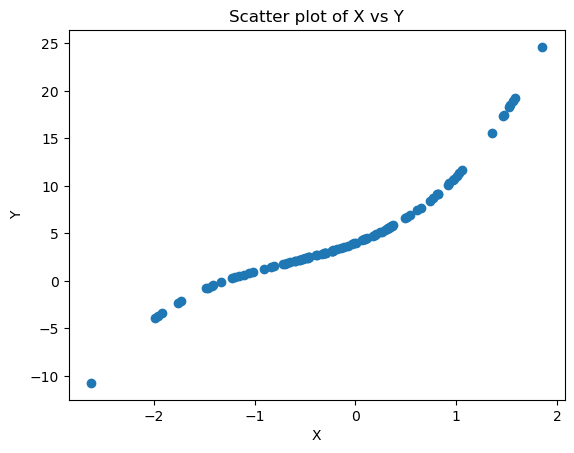

In [4]:
# plot the data
fig, ax = subplots()
ax.scatter(X, Y)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter plot of X vs Y')
fig.show()

- c) Use forward stepwise selection to select a model containing the predictors $X, X^2, ... , X^{10}$. What is the model obtained according to $C_p$? Report the coeffecients of the model obtained.

In [5]:
def nCp(sigma2, estimator, X, Y): # negative Cp statistic
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [12]:
# create a dataframe with the predictors and the response
df = pd.DataFrame({'Y': Y})
for i in range(1, 11):
    df[f'X^{i}'] = X**i
# move the response to the last column
df = df[['X^1', 'X^2', 'X^3', 'X^4', 'X^5', 'X^6', 'X^7', 'X^8', 'X^9', 'X^10', 'Y']]

design = MS(df.columns.drop('Y')).fit(df) # fit a model spec to the data (MS is a class that represents a model specification, which is a set of features)
Y = np.array(df['Y']) # the response variable
X = design.transform(df) # the design matrix with predictors
sigma2 = OLS(Y,X).fit().scale # the residual variance of the OLS model, .scale is the residual variance of the OLS model

neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

df_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
df_Cp.fit(df, Y)
df_Cp.selected_state_

('X^1', 'X^2', 'X^3')

The coefs from forward selection are the ones that were used to generate the data.  The added predictors are not significant, so they are not included in the model.

- d) Repeat (c), using backwards stepwise selection. How does your
answer compare to the results in (c)?

In [30]:
# use SFS for backward selection
# will need linear regression as the estimator

from sklearn.linear_model import LinearRegression


sfs = SFS(LinearRegression(),
            n_features_to_select=3,
            direction='backward',
            scoring=neg_Cp,
            cv=5)

sfs.fit(X, Y)
# get the selected features
# use the boolean array sfs.get_support() to get the selected features from X
selected_features = X.columns[sfs.get_support()]
selected_features

Index(['X^1', 'X^2', 'X^3'], dtype='object')

- e) Now fit a lasso model to the simulated data, again using $X, X^2, ... , X^{10}$ as predictors. Use cross-validation to select the optimal
value of λ. Create plots of the cross-validation error as a function
of λ. Report the resulting coefficient estimates, and discuss the
results obtained.

In [39]:
kfold = skm.KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X.reshape(-1,1), Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

# TODO: the rest

0.005125520522691081

- f) Now generate a response vector Y according to the model
$$
Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon
$$
and perform stepwise selection and the lasso. Discuss the results obtained.